# 4.2 Реализация генетического алгоритма
Реализовать генетический алгоритм решения задачи о рюкзаке, используя свой набор генетических операторов (определяется номером в списке и другими параметрами), и получить результаты на своем наборе данных (определяется номером в списке).

Шергалис Донат, 3530903/70301 Вариант 31.

In [1]:
var = 31
population_size = 200
population_division = 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import json
from operator import itemgetter 
from geneticalgorithm import geneticalgorithm as ga

In [3]:
def read_file(var = var):
    data_file = 'data/' + str(var) + '.txt'

    with open(data_file) as f:
        W, V = [int(x) for x in next(f).split()]

    data = pd.read_csv(data_file, 
                       skiprows=1,  
                       names=['w', 'v', 'c'], 
                       delim_whitespace=True)
    return data, W, V

In [4]:
data, W, V = read_file(var)
weights = len(data.index)

print(f'weights = {weights}') # количество весов
print(f'W = {W}') # грузоподъёмность
print(f'V = {V}') # вместимость

print('data: ')   # w = вес, v = объём, c = ценность
data.head()

weights = 30
W = 13000
V = 12
data: 


,w,v,c
0,897,0.6,167
1,138,0.6,293
2,1569,0.8,359
3,672,0.7,298
4,1514,0.4,265


In [5]:
def sum_col(solution, col):
    return round(sum(data[col][i] if s else 0 for i, s in enumerate(solution)), 5)

def sums(solution):
    return [sum_col(solution, col) for col in ['w', 'v', 'c']]

In [6]:
def valid(solution):
    w, v, c = sums(solution)
    return w <= W and v <= V

In [7]:
def filtrate(solutions):
    return [s for s in solutions if valid(s)]

In [8]:
def fitness(solution):
    w, v, c = sums(solution)
    return c if  w <= W and v <= V \
            else 0 # c / (min(w / V, 1.5) + min(v / V, 1.5))

In [9]:
def sort_solutions(solutions):
    sorted = list(solutions)
    sorted.sort(key=fitness, reverse=True)
    return sorted

In [10]:
def w(i):
    return data['w'][i]

def v(i):
    return data['v'][i]

def c(i):
    return data['c'][i]

In [11]:
def to_str(solution):
    return '[' + ''.join(['#' if i else ' ' for i in solution]) + ']'

# Условия

## 0. Кодирование – выбор «генетического кода»  
  Особь – битовая последовательность размера n (кол-во грузов)  

## 1. Начальная популяция – кол-во особей всегда = 200:  
  1.1 случайная генерация  
  1.2 **жадный выбор, начиная со случайного груза**  

In [12]:
list(range(weights))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [13]:
# берёт случайные элементы, пока не станет слишком много
def random_greedy_shuffled_solution():
    
    randomlist = list(range(weights))
    random.shuffle(randomlist)
    
    solution = [False] * weights
    sumW = 0
    sumV = 0
    
    for r in randomlist:
        if sumW + w(r) <= W and sumV + v(r) <= W:
            sumW += w(r)
            sumV += v(r)
            solution[r] = True
        else: 
            break

    return solution

# берёт подряд, начиная со случайного элемента, пока не станет слишком много
def random_greedy_solution():
    start = random.randint(0, weights - 1)
    end = start
    
    sumW = w(start)
    sumV = v(start)
    while end + 1 < weights \
            and sumW + w(end + 1) <= W \
            and sumV + v(end + 1) <= V:
        end += 1
        sumW = round(sumW + w(end), 5)
        sumV = round(sumV + v(end), 5)
    
    return [True if start <= i and i <= end else False for i in range(weights)]

In [14]:
population = [random_greedy_solution() for i in range(0, population_size)]

# demonstration
for s in population[:10]:
    print(to_str(s)) 

[                      ########]
[        ###########           ]
[                       #######]
[    #########                 ]
[  ##########                  ]
[         ############         ]
[        ###########           ]
[  ##########                  ]
[             ############     ]
[  ##########                  ]



## 2. Отбор особей для скрещивания:  
  2.1 выбор каждой особи пропорционально приспособленности (рулетка)  
  2.2 **выбрать только 20% самых приспособленных особей**  


In [15]:
def divide(solutions):
    sorted = sort_solutions(solutions)
    remains = round(len(solutions) / population_division)
    # top 20%, others, worst 20%
    return sorted[:remains], \
            sorted[remains:-remains], \
            sorted[-remains:]

## 3. Скрещивание (кроссинговер) между выбранными особями. 
Каждая особь скрещивается 1 раз за 1 поколение, 1 пара дает 2 потомка:   
  3.1 **многоточечный с 3мя точками**  
  3.2 однородный (каждый бит от случайно выбранного родителя)  

In [16]:

def intercourse(solution1, solution2):
    randomlist = random.sample(range(0, len(solution1)), 3)
    randomlist.sort()
    p1, p2, p3 = randomlist
    matrix = [True] * p1 \
            + [False] * (p2 - p1) \
            + [True] * (p3 - p2) \
            + [False] * (len(solution1) - p3)
    
    zipped = list(zip(matrix, solution1, solution2))
    
    c1 = [s1 if     w else s2 for w, s1, s2 in zipped]
    c2 = [s1 if not w else s2 for w, s1, s2 in zipped]
    
    return c1, c2


## 4. Мутация:  
  4.1 **инвертирование всех битов у 1 особи**  
  4.2 случайное изменение 3х битов у 5% особей  
  4.3 добавление 1 случайной вещи 5% особей  

In [17]:
def mutate(solutions):
    for i in range(0, 50): # несколько раз пробуем, может не получиться
        r = random.randint(0, len(solutions) - 1)
        mutant = [not s for s in solutions[r]]
        if fitness(mutant) > 0:
            solutions[r] = mutant
            return

## 5. Формирование новой популяции (кол-во особей - константа)  
  5.1 замена 20% худших особей из предыдущего поколения на лучших потомков  
  5.2 «штраф» за «старость» - 10% функции приспособленности, выбор лучших  
  5.3 **замена своих родителей**  

In [18]:
def make_children(parents):
    children = []
    parents = list(parents)
    random.shuffle(parents)
    while len(parents) >= 2:
        children += intercourse(parents.pop(), parents.pop())
    return children

In [19]:
def new_gen(solutions):
    top, others, worst = divide(solutions)
    new_gen = top + others + make_children(top)
    # new_gen = make_children(top) + others + worst
    # new_gen = make_children(top + others) + worst
    mutate(new_gen)
    clean_gen(new_gen)
    return new_gen

### Очистка популяции: 
Избавляемся от нежизнеспособных ребят, заменяя их на свежесгенерированных:

In [20]:
def clean_gen(solutions):
    for i, s in enumerate(solutions):
        if fitness(s) == 0:
            solutions[i] = random_greedy_shuffled_solution()

## 6. Оценка результата  
Наступила сходимость (функция приспособленности лучшей особи в популяциях отличается не более, чем на стоимость самой дешевой вещи) или прошло 500 поколений

In [21]:
min_price = min(data['c'])
print("min price = " + str(min_price))

def enough(gen, population, the_best):
    sorted_filtered = sort_solutions(filtrate(population))
    best = sorted_filtered[0]
    
    print(gen, fitness(best), to_str(best))
    
    is_enough = (gen >= 200 or fitness(best) - fitness(sorted_filtered[-1]) <= min_price)
    the_best = select_the_best(best, the_best)

    return is_enough, the_best

min price = 117


In [22]:
def select_the_best(best, the_best):
    best_fitnesses.append(fitness(best))
    return best if fitness(best) > fitness(the_best) else the_best

 ## Алгоритм итерирования
 1. Начальная популяция - `random_greedy_solution()`
 2. Отбор - `divide()`
 3. Скрещивание - `intercourse()`
 4. Мутация - `mutate()`
 5. Новая популяция - `new_gen()`
 6. Если результат не достигнут, перейти к п.2 - `enough()`
 7. Результирующая популяция - `result_gen`, лучшее решение `the_best`
 

In [23]:
best_fitnesses = []

def iterate(population, gen = 0, the_best = population[0]):
    assert len(population) == population_size
    
    is_enough, the_best = enough(gen, population, the_best)

    if is_enough:
        return population, the_best
    else:
        return iterate(new_gen(population), gen + 1, the_best)

result_gen, the_best = iterate(population)
print()

0 3557 [           #############      ]
1 4184 [ ###  ##   #   # ###### #     ]
2 4184 [ ###  ##   #   # ###### #     ]
3 4184 [ ###  ##   #   # ###### #     ]
4 4184 [ ###  ##   #   # ###### #     ]
5 4184 [ ###  ##   #   # ###### #     ]
6 4184 [ ###  ##   #   # ###### #     ]
7 4184 [ ###  ##   #   # ###### #     ]
8 4184 [ ###  ##   #   # ###### #     ]
9 4184 [ ###  ##   #   # ###### #     ]
10 4322 [####  ###      # ######       ]
11 4322 [####  ###      # ######       ]
12 4322 [####  ###      # ######       ]
13 4322 [####  ###      # ######       ]
14 4322 [####  ###      # ######       ]
15 4345 [####  ##   #   # #####     # #]
16 4397 [####  ###      #######        ]
17 4525 [####    ## #   #######       #]
18 4525 [####    ## #   #######       #]
19 4525 [####    ## #   #######       #]
20 4525 [####    ## #   #######       #]
21 4640 [ ###  ###  #   #######       #]
22 4640 [ ###  ###  #   #######       #]
23 4640 [ ###  ###  #   #######       #]
24 4640 [ ###  ###  #   ##

In [24]:
print('The best:', fitness(the_best), to_str(the_best))

The best: 4640 [ ###  ###  #   #######       #]


In [25]:
for s in sort_solutions(result_gen)[:5]:
    print(to_str(s) + ' = ' + str(fitness(s)))

[ ###  ###  #   #######       #] = 4640
[ ###  ###  #   #######       #] = 4640
[ ###  ###  #   #######       #] = 4640
[ ###  ###  #   #######       #] = 4640
[ ###  ###  #   #######       #] = 4640


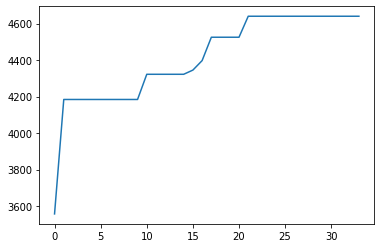

In [26]:
plt.plot(best_fitnesses)

In [27]:
indexes = [i for i, s in enumerate(sort_solutions(result_gen)[0]) if s]

result = data.iloc[indexes,:]

print(f"W = {sum(result['w'])}")
print(f"V = {round(sum(result['v']), 2)}")
print(f"C = {sum(result['c'])}")
result

W = 12670
V = 11.6
C = 4640


,w,v,c
1,138,0.6,293
2,1569,0.8,359
3,672,0.7,298
6,1215,0.7,278
7,1292,0.6,360
8,996,0.6,320
11,716,0.7,214
15,1534,0.9,377
16,1066,0.6,351
17,714,1.1,301
